In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import moviepy.editor as mpy
import os
from moviepy.video.io.bindings import mplfig_to_npimage
import HUXt as H
import astropy.units as u
from skimage import measure
import scipy.ndimage as ndi
%matplotlib inline

Add in CME tracker.
 - identify contiguous regions between diff of ambient and cme fields.
 - count the cmes and label as they go out. 
Add in empirical rule for density of ambient and CME.
Write Thomson scattering simulator for the 2-d solutions. 

In [2]:
# Set up HUXt1D to run a 5 day simulation of Carrington rotation 2000, and output model data every 4 timesteps (about 35min)
cr_num = 2000
lon = 0.0
model1D = H.HUXt1D(cr_num, lon=lon, simtime=5, dt_scale=4)

# Get a list of different CMEs with random launch longitudes and times
cme_list=[]
n_cme = 5
launch_lons = [10 for i in range(n_cme)]
#launch_lons = np.random.randint(0, 360, n_cme)
daysec = 86400
launch_times = [(0.25 + i*4/n_cme)*daysec for i in range(n_cme)]
               
for lon, t_launch in zip(launch_lons, launch_times):
    #print(lon, t_launch)
    cme = H.ConeCME(t_launch=t_launch, longitude=lon, width=30, v=1000, thickness=5)
    cme_list.append(cme)
    
# Run HUXt1D for these cmes, save to file 
tag = 'test'
model1D.solve(cme_list, save=True, tag=tag)

In [3]:
# Set up HUXt2D to run a simulation with the same parameters.
model2D = H.HUXt2D(cr_num, simtime=5, dt_scale=4)

# Run for the same list of cmes, save to file 
tag = 'test_rand_lon'
model2D.solve(cme_list, save=True, tag=tag) 

# Make an MP4 of the solution with CME
model2D.animate('cme', tag)

t:   0%|                                                                             | 0/240 [00:00<?, ?it/s, now=None]

Moviepy - Building video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR2000_test_rand_lon_movie.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR2000_test_rand_lon_movie.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR2000_test_rand_lon_movie.mp4


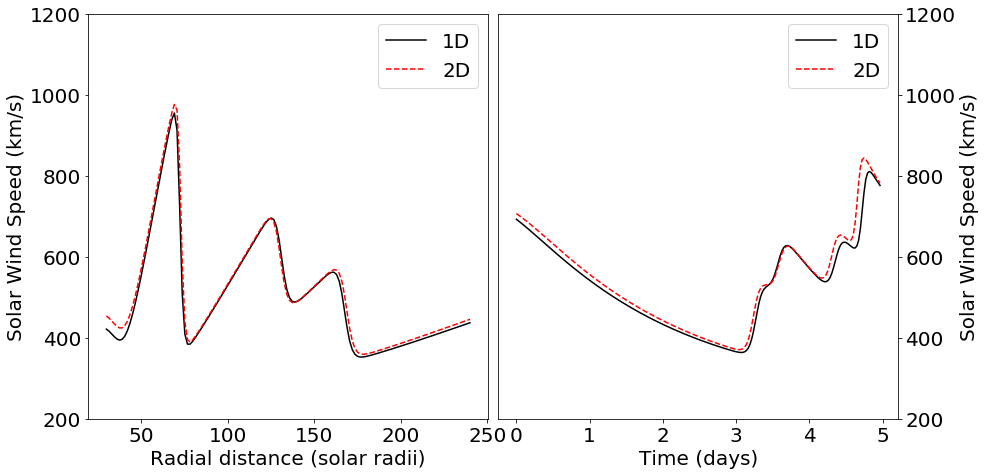

In [4]:
# Show both solutions match along the selected longitude
# Find index of the selected longitude, a time, and approx 1AU.
id_lon = np.argmin(np.abs(model2D.lon.value - model1D.lon.value))
id_t = 100
id_r = np.argmin(np.abs(model2D.r.value - 215))

fig, ax = plt.subplots(1,2, figsize=(12.5,6.25))
ax[0].plot(model1D.r, model1D.v_grid_cme[id_t, :], 'k-', label='1D')
ax[0].plot(model2D.r, model2D.v_grid_cme[id_t, :, id_lon], 'r--', label='2D')

ax[1].plot(model1D.time_out.to(u.day), model1D.v_grid_cme[:, id_r], 'k-', label='1D')
ax[1].plot(model2D.time_out.to(u.day), model2D.v_grid_cme[:, id_r, id_lon], 'r--', label='2D')

for a in ax:
    a.legend()
    a.set_ylim(200,1200)
    a.set_ylabel('Solar Wind Speed (km/s)')
    
ax[0].set_xlabel('Radial distance (solar radii)')
ax[1].set_xlabel('Time (days)')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
    
fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.025)

Logic for the CME detector:

- find logical array of cme-amb>20.
- loop through detection array and find contiguous regions.
    - must hand wrapping around longitude axis. 
- label each CME to track as it moves out
    - at time t, label 0-n, with n increasing with decreasing maximum radial distance of each contiguous region.
    - at t+1, look for any union with cmes at t, and transfer labels. when cmes merge, lower label number takes priority.
    
    

In [5]:
def plot_cme(model, diff, cme, t):
    # Get plotting data
        lon = model.lon_grid.value.copy()
        rad = model.r_grid.value.copy()
        v = diff.value[t, :, :].copy()
        cid = cme[t, :, :].copy()
        
        # Pad out to fill the full 2pi of contouring
        pad = lon[:, 0].reshape((lon.shape[0], 1)) + model.twopi
        lon = np.concatenate((lon, pad), axis=1)
        pad = rad[:, 0].reshape((rad.shape[0], 1))
        rad = np.concatenate((rad, pad), axis=1)
        pad = v[:, 0].reshape((v.shape[0], 1))
        v = np.concatenate((v, pad), axis=1)
        pad = cid[:, 0].reshape((cid.shape[0], 1))
        cid = np.concatenate((cid, pad), axis=1)
        
        mymap = mpl.cm.magma
        mymap.set_over([1, 1, 1])
        mymap.set_under([0, 0, 0])
        dv = 10
        levels = np.arange(0, 1000+dv, dv)
        fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": "polar"})
        cnt = ax.contourf(lon, rad, v, levels=levels, cmap=mymap, extend='both')
        
        ax.contour(lon, rad, cid, levels=[1.0], colors='y')
        ax.set_ylim(0, 230)
        ax.set_yticklabels([])
        ax.tick_params(axis='x', which='both', pad=15)
        ax.patch.set_facecolor('slategrey')
        fig.subplots_adjust(left=0.05, bottom=0.2, right=0.95, top=0.95)
        
        # Add colorbar
        pos = ax.get_position()
        dw = 0.005
        dh = 0.075
        left = pos.x0 + dw
        bottom = pos.y0 - dh
        wid = pos.width - 2*dw
        cbaxes = fig.add_axes([left, bottom, wid, 0.03])
        cbar1 = fig.colorbar(cnt, cax=cbaxes, orientation='horizontal')
        cbar1.ax.set_xlabel("Solar Wind Speed (km/s)")
        
        # Add label
        label = "Time: {:3.2f} days".format(model.time_out[t].to(u.day).value)
        fig.text(0.675, 0.17, label, fontsize=20)
        label = "HUXt2D"
        fig.text(0.175, 0.17, label, fontsize=20)
        return fig, ax 

NameError: name 'diff' is not defined

[2]
[2]
[2]
[1]


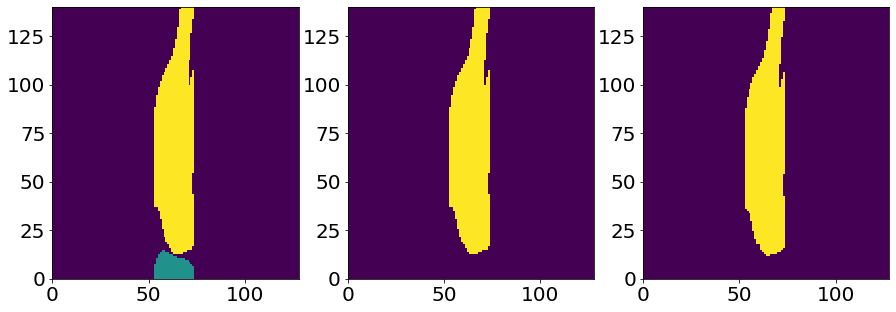

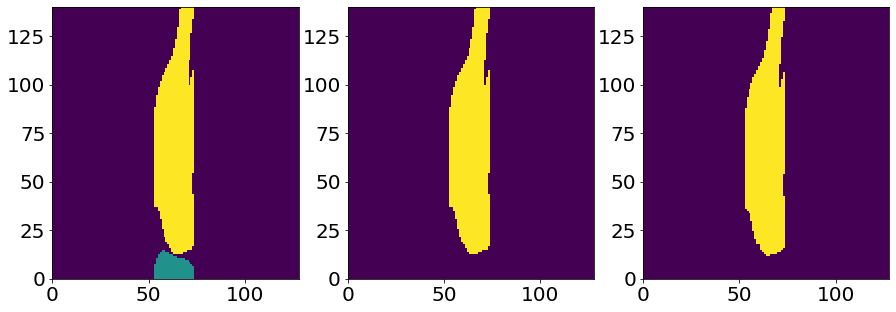

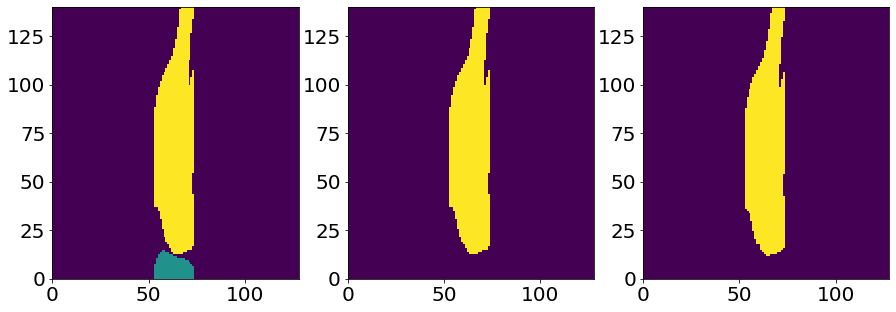

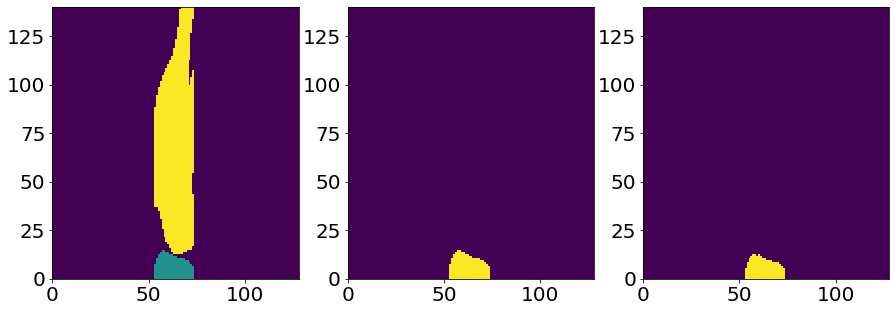

In [16]:
diff = model2D.v_grid_cme - model2D.v_grid_amb
cme_bool = diff >= 20 * model2D.kms

# Loop through CME list
# Find index of middle longitude for centering arrays on the CMEs
id_mid_lon = np.argmin(np.abs(model2D.lon - np.median(model2D.lon)))

all_cme_coords = []
for i,cme in enumerate(cme_list):
    # Get index of CME longitude
    id_cme_lon = np.argmin(np.abs(model2D.lon - cme.longitude))
    
    j_cme = 0
    all_coords = {j:{'x':[],'y':[]} for j in range(model2D.Nt_out)}
    for j, t in enumerate(model2D.time_out):
        
        if t < cme.t_launch:
            continue
        
        cme_bool_t = cme_bool[j, :, :]
        # Center the solution on the CME longitude to avoid edge effects
        center_shift = id_mid_lon - id_cme_lon
        cme_bool_t = np.roll(cme_bool_t, center_shift, axis=1)
        
        # measure seperate CME regions.
        cme_label, n_cme = measure.label(cme_bool_t.astype(int), connectivity=1, background=0, return_num=True)
        cme_tags = [i for i in range(1,n_cme+1)]
        
        if j_cme == 0:
            j_first = j
            # Find only the label in the origin region of this CME    
            target = np.zeros(cme_bool_t.shape)
            half_width = cme.width / (2*model2D.dlon)
            left_edge = np.int32(id_mid_lon - half_width)
            right_edge = np.int32(id_mid_lon + half_width)
            target[0,left_edge:right_edge] = 1
            # Find the CME label that intersects this region
            matches = []
            for label in cme_tags:
                this_label = cme_label == label
                id_matches = np.any(np.logical_and(target, this_label))
                if id_matches:
                    matches.append(label)
        else:
            # Find only the label that intersects with previous solution.
            matches = []
            for label in cme_tags:
                this_label = cme_label == label
                # THIS IS WHERE THE ISSUE WITH FRAME 116 is. Looking one step back can be ambiguous. 
                # With more than one label, count the intersection, go with largest.
                id_matches = np.any(np.logical_and(previous_cme, this_label))
                if id_matches:
                    matches.append(label)
                
        # Check only one match
        if len(matches) != 1:
            print("Warning, more than one match found, taking first match only")

        # Find the coordinates of this region and stash 
        match_id = matches[0]
        cme_id = cme_label==match_id
        # Fill holes in the labelled region.
        cme_id_filled = ndi.binary_fill_holes(cme_id)
        coords = measure.find_contours(cme_id_filled, 0.5)
        
        # Contour can be broken at inner and outer boundary, so stack broken contours
        if len(coords) == 1:
            coord_array = coords[0]
        elif len(coords) > 1:
            #coord_array = coords[0]
            coord_array = np.vstack(coords)   
        
        if j == 116:
            print(matches)
            fig, ax = plt.subplots(1,3,figsize=(15,5))
            ax[0].pcolor(cme_label)
            ax[1].pcolor(cme_id)
            ax[2].pcolor(previous_cme)
            #ax.plot(coord_array[:, 1], coord_array[:, 0], 'r--')
            #break
            
        rows = coord_array[:, 0]
        cols = coord_array[:, 1] - center_shift
        # Correct running off of left hand side
        cols[cols<0] += model2D.Nlon
        all_coords[j]['x'] = cols
        all_coords[j]['y'] = rows
        previous_cme = cme_id.copy()
        j_cme = j_cme + 1
    
    all_cme_coords.append(all_coords)

In [18]:
def plot_cme_v2(model, diff, cme_coords, t):
    # Get plotting data
        lon = model.lon_grid.value.copy()
        rad = model.r_grid.value.copy()
        v = diff.value[t, :, :].copy()
                
        # Pad out to fill the full 2pi of contouring
        pad = lon[:, 0].reshape((lon.shape[0], 1)) + model.twopi
        lon = np.concatenate((lon, pad), axis=1)
        pad = rad[:, 0].reshape((rad.shape[0], 1))
        rad = np.concatenate((rad, pad), axis=1)
        pad = v[:, 0].reshape((v.shape[0], 1))
        v = np.concatenate((v, pad), axis=1)
        
        mymap = mpl.cm.magma
        mymap.set_over([1, 1, 1])
        mymap.set_under([0, 0, 0])
        dv = 10
        levels = np.arange(0, 1000+dv, dv)
        fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": "polar"})
        cnt = ax.contourf(lon, rad, v, levels=levels, cmap=mymap, extend='both')
        
        colours = ['y', 'c', 'm', 'g', 'b', 'w']
        for kkk, cme in enumerate(cme_coords):
            lon_pix = cme[t]['x']
            rad_pix = cme[t]['y']
            lon = np.interp(lon_pix, np.arange(0,model2D.Nlon), model2D.lon.value)
            rad = np.interp(rad_pix, np.arange(0,model2D.Nr), model2D.r.value)
            ax.plot(lon, rad,'--', color=colours[kkk])

        ax.set_ylim(0, 230)
        ax.set_yticklabels([])
        ax.tick_params(axis='x', which='both', pad=15)
        ax.patch.set_facecolor('slategrey')
        fig.subplots_adjust(left=0.05, bottom=0.2, right=0.95, top=0.95)
        
        # Add colorbar
        pos = ax.get_position()
        dw = 0.005
        dh = 0.075
        left = pos.x0 + dw
        bottom = pos.y0 - dh
        wid = pos.width - 2*dw
        cbaxes = fig.add_axes([left, bottom, wid, 0.03])
        cbar1 = fig.colorbar(cnt, cax=cbaxes, orientation='horizontal')
        cbar1.ax.set_xlabel("Solar Wind Speed (km/s)")
        
        # Add label
        label = "Time: {:3.2f} days".format(model.time_out[t].to(u.day).value)
        fig.text(0.675, 0.17, label, fontsize=20)
        label = "HUXt2D"
        fig.text(0.175, 0.17, label, fontsize=20)
        return fig, ax 

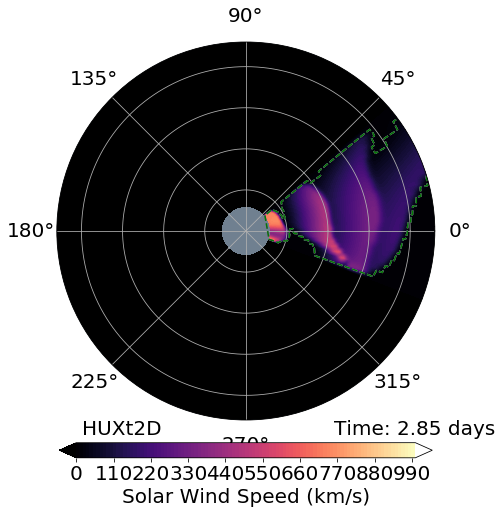

In [20]:
fig, ax = plot_cme_v2(model2D, diff, all_cme_coords, 117)

In [21]:
duration = model2D.simtime.value * (10 / 432000)

def make_frame(t):
    """
    Function to produce the frame required by MoviePy.VideoClip.
    """
    # Get the time index closest to this fraction of movie duration
    i = np.int32((model2D.Nt_out-1) * t / duration)
    fig, ax = plot_cme_v2(model2D, diff, all_cme_coords, i)
    frame = mplfig_to_npimage(fig)
    plt.close('all')           
    return frame

filename = "TEST_CME_DETECT_rand_lon.mp4"
filepath = os.path.join(model2D._figure_dir_, filename)
animation = mpy.VideoClip(make_frame, duration=duration)
animation.write_videofile(filepath, fps=24, codec='libx264')

t:   0%|                                                                             | 0/240 [00:00<?, ?it/s, now=None]

Moviepy - Building video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\TEST_CME_DETECT_rand_lon.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\TEST_CME_DETECT_rand_lon.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\TEST_CME_DETECT_rand_lon.mp4
